In this code we will make diferent simulations (calculate Jsc from EQE and spectra data) in order to understand why it is difficult to obtain the EQE from the real data. We will be playing with the noise and the shape of the stepfucntion in the C-matrix. 

First we load the necessary packages and some usefull functions

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy.polynomial

In [15]:
def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]

def closest_indx(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx     
     
def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1) #
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def FD_dist(HWHM, center, wavelengths_to_evaluate, height = 1):
    return height*(1/(1+np.exp((center-wavelengths_to_evaluate)/HWHM)))

In [20]:
def c_matrix_generator(
input_spectra_fit,                  #This is the full spectra to generate the c_matrix
Red_sweep = True,               #If you want a red sweap, this should be True, if it is False then blue sweep is calculated.
Derivative = False,             #If true, the output gives also the derivative of each spectra with respect to the wavelength. 
Real_data = False,              #If true, we will need to pass the stepf_parameters matrix of the corresponding sweep.
stepf_parameters = 0,           #This is a numpy array containing the RScutwl, center, heigth, hwhm and constant of the stepfunction. (RScutwl is the reference cut wavelength that we have, but for the funtion of the stepfunction one takes the realcutwl which shold be the same for a RS but different for a BS)
c_matrix_min_wl = 400,          #The minimum wavelength of the c_matrix spectras (and also the resulting EQE). Redomended value 400 because it is the minimum of EQE measures
c_matrix_max_wl = 1000,         #The maximum wavelength of the c_matrix spectras (and also the resulting EQE). Recomended value 1000
c_matrix_res_wl = 1,            #The wavelength resolution of the c_matrix spectras (and also the resultin EQE)
c_matrix_min_cutwl = 400,       #The minimum cuting wavelength of the c_matrix spectras
c_matrix_max_cutwl = 810,       #The maximum cutting wavelength of the c_matrix spectras
c_matrix_res_cutwl = 5,        #The cutting wavelength spacing of the c_matrix spectras
c_matrix_stepf_HWHM = 5        #Define the value of this parameter
):
    if not Real_data:
        full_spectra_irradiance_fit = input_spectra_fit
        c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)      #These are the wavelengths wherein the c_matrix is evaluated horizontally (its spectras, and therefore the EQE)
        c_matrix_cutwl = np.arange(c_matrix_min_cutwl, c_matrix_max_cutwl, c_matrix_res_cutwl)  #There are the wavelengths wehrein the c_matrix is evaluated verticlaly (therefore, the different cutting wavelengths)
        c_matrix_RS_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))                   #We initialize the red sweep and blue sweep metor matrix
        c_matrix_BS_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))
        c_matrix_full_spectra = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))               #And also the matrix containing all the full spectras for its multiplication with the motor matrix
        
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_RS_motor[i,:] = FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)       #We define each row of the RS motor matrix with the FD stepfunction distribution
            c_matrix_BS_motor[i,:] = FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)      #The same for the BS motor, in this case the FWHM has to be negative in order to have the blue part of the spectra
            
            if Derivative:                                                                          #If the derivative mode is activated
                c_matrix_RS_motor_derivative = np.zeros(c_matrix_RS_motor.shape)                    #we also need to initialize both RS and BS motor derivative matrices
                c_matrix_BS_motor_derivative = np.zeros(c_matrix_BS_motor.shape)
                for i in range(len(c_matrix_full_spectra[:,0])):
                    c_matrix_RS_motor_derivative [i,:] = FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)*(1-FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl))  #And calculate them
                    c_matrix_BS_motor_derivative [i,:] = FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)*(1-FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl))

        c_matrix_spectra_single = np.zeros(c_matrix_wl.shape)                                           #We also do the same with the c_matrix full spectra previously fited with splines
        for j in range(len(c_matrix_wl)):                                                           #But in this case we need to make the average around each c_matrix_wl
            actual_wl = c_matrix_wl[j]
            actual_spectra_average = statistics.mean(full_spectra_irradiance_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
            c_matrix_spectra_single[j] = 0.1*actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
            #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in mA/cm^2 (in thsi case for the full spectra)
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_full_spectra [i,:] = c_matrix_spectra_single 

    if Real_data:
        full_spectra_irradiance_fit = input_spectra_fit
        c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)      #These are the wavelengths wherein the c_matrix is evaluated horizontally (its spectras, and therefore the EQE)
        c_matrix_cutwl = stepf_parameters[:,0]                              #There are the wavelengths wehrein the c_matrix is evaluated verticlaly (therefore, the different cutting wavelengths)
        c_matrix_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))                   #We initialize the red sweep and blue sweep metor matrix. In this case, because the positive/negative information is already presnt in the stepf matrix information, we will define a single motor matrix
        c_matrix_full_spectra = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))               #And also the matrix containing all the full spectras for its multiplication with the motor matrix
        
        for i in range(len(c_matrix_full_spectra[:,0])):
            actual_RScutwl, actual_cutwl, actual_heigh, actual_hwhm, actual_constant = stepf_parameters[i,:]
            c_matrix_motor[i,:] = FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=actual_heigh) + actual_constant      #We define each row of the RS motor matrix with the FD stepfunction distribution
            
            if Derivative:                                                                          #If the derivative mode is activated
                c_matrix_motor_derivative = np.zeros(c_matrix_motor.shape)                    #we also need to initialize both RS and BS motor derivative matrices
                for i in range(len(c_matrix_full_spectra[:,0])):
                    c_matrix_motor_derivative [i,:] = FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=actual_heigh)*(1-FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=actual_heigh))  #And calculate them
                    

        c_matrix_BS_motor = c_matrix_motor          #Finally, when the motor matrix is constucted we define the BS and RS motor matrixes as this one, and what we choose initially will return the correct one. 
        c_matrix_RS_motor = c_matrix_motor
        c_matrix_BS_motor_derivative = c_matrix_motor_derivative
        c_matrix_RS_motor_derivative = c_matrix_motor_derivative

        c_matrix_spectra_single = np.zeros(c_matrix_wl.shape)                                           #We also do the same with the c_matrix full spectra previously fited with splines
        for j in range(len(c_matrix_wl)):                                                           #But in this case we need to make the average around each c_matrix_wl
            actual_wl = c_matrix_wl[j]
            actual_spectra_average = statistics.mean(full_spectra_irradiance_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
            c_matrix_spectra_single[j] = 0.1*actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
            #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in mA/cm^2 (in thsi case for the full spectra)
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_full_spectra [i,:] = c_matrix_spectra_single 

    if not Derivative:    #If the derivative option is False, we just return the c_matrix
        if Red_sweep:
            c_matrix = c_matrix_RS_motor*c_matrix_full_spectra
        else:
            c_matrix = c_matrix_BS_motor*c_matrix_full_spectra

        return (c_matrix, c_matrix_wl, c_matrix_cutwl)
    
    if Derivative:      #If the derivative option is True, we calculate and return the c_matrix_derivative
        if Red_sweep:
            c_matrix = c_matrix_RS_motor*c_matrix_full_spectra
            c_matrix_derivative = c_matrix_RS_motor_derivative*c_matrix_full_spectra
        else:
            c_matrix = c_matrix_BS_motor*c_matrix_full_spectra
            c_matrix_derivative = c_matrix_BS_motor_derivative*c_matrix_full_spectra

        return (c_matrix, c_matrix_derivative, c_matrix_wl, c_matrix_cutwl)


#This function takes a c_matrix and makes the derivative of it in the vertical direction (along the cuting wavelength direction)
def c_matrix_vertical_derivative (
c_matrix,               #The c_matrix in question
c_matrix_cutwl,         #The cutting wavelength vector of the c_matrix
s_factor=0              #The factor that 
):
    c_matrix_vderivative = np.zeros(c_matrix.shape)
    for j in range(len(c_matrix[0,:])):
        actual_spl_fit = interpolate.UnivariateSpline(c_matrix_cutwl, c_matrix[:,j], s=s_factor)
        c_matrix_vderivative [:,j] = -actual_spl_fit.derivative(n=1)(c_matrix_cutwl)

    return c_matrix_vderivative
    
#This function takes a c_matrix and puts a certain noise to it. 
def c_matrix_noise_adder(
c_matrix_input,             #The c_matrix to put noise
percentage):                #The maximum percentage of this noise (the noise added at each poing will be in between +- this percentage to the magnitude at that point)
    c_matrix_input_noise = np.zeros(c_matrix_input.shape)
    for j in range(len(c_matrix_input[:,0])):
        for i in range(len(c_matrix_input[0,:])):
            c_matrix_input_noise[j,i] = c_matrix_input[j,i]*(100+percentage*np.random.random_sample())/100
    
    return c_matrix_input_noise

#This function is useful to plot all the spectras of a given c_matrix
def c_matrix_plotter(
c_matrix,                   #The c_matrix to plot
c_matrix_wl,                #The correponding c_matrix wavelength vector
legend = False,             #True for plotting the legend
plotsize = (14,6)):        #True for plotting the legend

    fig, ax = plt.subplots(figsize=plotsize)
    for i in range(len(c_matrix[:,0])):
        ax.plot(c_matrix_wl,c_matrix[i,:])
    plt.xlabel('Wavelength [nm]')

#This function is used to calculate the Jsc
def Jsc_calculator(
full_spectra_irradiance,        #The full spectra irradiance imput
wl_resolution,                  #The wavelenegth resolution of the calculations
real_EQE_interp,                #The interpolation function of the measured EQE
noise_percentage = 0            #The noise percentage added to the Jsc curve
):
    calculated_Jsc_c_matrix_RS, calculated_Jsc_c_matrix_wl_RS, calculated_Jsc_c_matrix_cutwl_RS = c_matrix_generator(full_spectra_irradiance, Red_sweep=True, Derivative = False, c_matrix_res_wl=wl_resolution)
    calculated_Jsc_c_matrix_BS, calculated_Jsc_c_matrix_wl_BS, calculated_Jsc_c_matrix_cutwl_BS = c_matrix_generator(full_spectra_irradiance, Red_sweep=False, Derivative = False, c_matrix_res_wl=wl_resolution)
    calculated_Jsc_RS = np.zeros(len(calculated_Jsc_c_matrix_RS[:,0]))
    calculated_Jsc_BS = np.zeros(len(calculated_Jsc_c_matrix_BS[:,0]))
    for i in range(len(calculated_Jsc_c_matrix_RS[:,0])):
        calculated_Jsc_RS[i] = sum(calculated_Jsc_c_matrix_RS[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
        calculated_Jsc_RS[i] = calculated_Jsc_RS[i]*(100+noise_percentage*np.random.random_sample())
        calculated_Jsc_BS[i] = sum(calculated_Jsc_c_matrix_BS[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
        calculated_Jsc_BS[i] = calculated_Jsc_BS[i]*(100+noise_percentage*np.random.random_sample())
    return calculated_Jsc_RS, calculated_Jsc_BS, calculated_Jsc_c_matrix_cutwl_RS, calculated_Jsc_c_matrix_cutwl_BS 

Load the EQE and Solar Spectra

In [8]:
real_EQE_filename = 'MCV.210602.OT2.labona.L.04.txt' #Name of the file containing the EQE measure inside the folder EQEs
spectras_folder = '04OctubreCalibrationCutWL' #Name of the folder with the blue and red calibration spectras, which is inside the main folder

real_EQE = np.loadtxt(os.path.join(os.getcwd(), 'EQEs',real_EQE_filename), skiprows=1)  #Load the real EQE information
real_EQE_interp = interpolate.interp1d(real_EQE[:,0], real_EQE[:,1])

RS_txt_filelist = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Red Sweep Opening'))   #Remember to add 0 to the firsts file names!!
BS_txt_filelist = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Blue Sweep Opening')) #Remember to add 0 to the firsts file names!!
area_factor = 0.5543/5.067
int_time = 0.001*0.6
k_filepath = 'flame_to_irradiance_calibrationfile.txt'
spectra_data_red = None
spectra_data_blue = None
RS_bg_spectra = np.loadtxt(os.path.join(spectras_folder, 'Red Sweep Opening',RS_txt_filelist[0]), skiprows=1)       #We load the red sweep background spectra
RS_full_spectra = np.loadtxt(os.path.join(spectras_folder, 'Red Sweep Opening',RS_txt_filelist[-1]), skiprows=1)    #And the red sweep full spectra (corresponding to the position 50 of the blue motor)
RS_full_spectra [:,1] = RS_full_spectra [:,1] - RS_bg_spectra [:,1]                                                 #And we substract the background to the full spectra
#                                                                                                                   #We repeat the same process but for the blue sweep
BS_bg_spectra = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening', BS_txt_filelist[0]), skiprows=1)     #Load the blue sweep background spectra
BS_full_spectra = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening',BS_txt_filelist[-1]), skiprows=1)    #Load the blue sweep full spectra
BS_full_spectra [:,1] = BS_full_spectra [:,1] - BS_bg_spectra [:,1]                                                 #Substract the BG to the full spectra

full_spectra = BS_full_spectra                                         #And finally we define a global spectra as the average between RS and BS full spectras:
full_spectra [:,1] = (BS_full_spectra[:,1]+RS_full_spectra[:,1])/2
full_spectra_irradiance = counts_to_irradiance(full_spectra,int_time,k_filepath) #And we pass it to irradiance
full_spectra_irradiance_fit = interpolate.UnivariateSpline(full_spectra_irradiance[:,0],full_spectra_irradiance[:,1], s=0.06)


Text(0, 0.5, 'Irradiance [W/m^2/nm]')

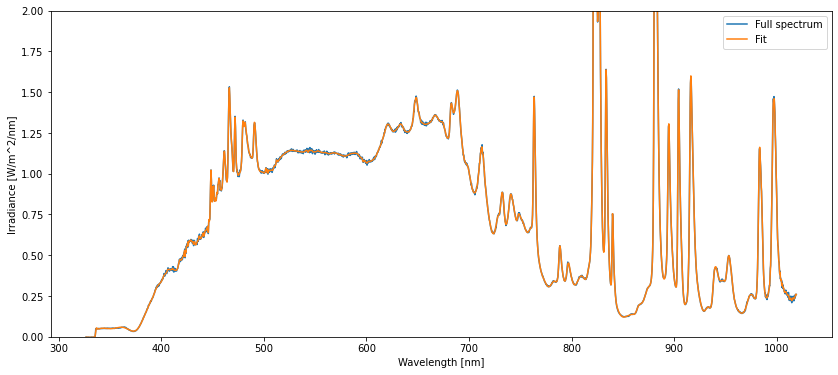

In [9]:
#Here we plot the full spectra irradiance to ckech that everithing is OK.
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(full_spectra_irradiance[:,0], full_spectra_irradiance[:,1], label ='Full spectrum')
ax.plot(full_spectra_irradiance[:,0], full_spectra_irradiance_fit(full_spectra_irradiance[:,0]), label = 'Fit')
plt.ylim(0,2)
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Irradiance [W/m^2/nm]')

Load cell measurements

In [14]:
#We load the measurements:
device_filename = 'Device 0830ThY61 - L'    #Here write the folder name of your device
cell_filename = 'L.02'                      #Here put the folder name of the cell of your device
measures_filepath = os.path.join(os.getcwd(), 'RainbowMeasures', device_filename, 'TXT files', cell_filename)
measures_filepath_list = os.listdir(measures_filepath)
for file in measures_filepath_list:
    if '.txt' in file:
        measures_filepath = os.path.join(measures_filepath, file)
        print(measures_filepath)

measurement_data= np.loadtxt(measures_filepath, skiprows=1)   
measure_divwl = measurement_data[:,0]
measure_Jsc = -0.1*measurement_data[:,2]
measure_Jsc = numpy.polynomial.polynomial.Polynomial.fit(measure_divwl, measure_Jsc, 10)(measure_divwl)

for i in range(len(measure_Jsc)):
    measure_Jsc[i] = measure_Jsc[i]-measure_Jsc[0]


measure_divwl = measurement_data[:,0]
min_cutwl = np.min(measure_divwl)
#min_cutwl = 410
max_cutwl = np.max(measure_divwl)
inc_cutwl = abs(min_cutwl-max_cutwl)/(len(measure_divwl)-1)
print(min_cutwl, max_cutwl)

c:\Users\UX490UA\Documents\GitHub\SOLS-EQE\Numeric method - second try\RainbowMeasures\Device 0830ThY61 - L\TXT files\L.02\MCV.211005.0830ThY61.1Sun_210930..Red Sweep Opening.txt
400.0 810.0


Construct the C matrix

In [21]:
#Here we
def BS_center (x):
    return 383.869 + 3.98732*x + -0.611785*x**2 + 0.0657888*x**3 + -0.00287418*x**4 + 5.96164e-005*x**5 + -4.6142e-007*x**6

def BS_heigth (x):
    return -0.100724 + (0.925577+0.100724)/(1+np.exp((43.9222-x)/-1.69024)) + 0.0415326 + -0.00118571 * x

def BS_hwhm (x):
    return 5.35907 + 0.207287*x + -0.0125499*x**2 + 0.000429092*x**3

def BS_constant (x):
    return 0.059178 + (1.08901-0.059178)/(1+np.exp((43.8892-x)/1.68989)) + -0.0127136 + 0.000803631 * x

def RS_center (x): 
    return 1014.05 + -41.07*x + 0.56503*x**2 + 0.0512571*x**3 + -0.00272469*x**4 + 5.08175e-005*x**5 + -3.35389e-007*x**6
def RS_heigth (x):
    return -1.39321 + (0.951288-1.39321)/(1+np.exp((50.5828-x)/-6.73346)) + -0.0417014 + 0.00385467 * x

def RS_hwhm (x):
    return 65.9859 + -4.45701*x + 0.11475*x**2 + -0.00102199*x**3

def RS_constant (x):
    return 0.0426264 + (1.67289-0.0426264)/(1+np.exp((48.0813-x)/5.28878))

# fityk_RS = np.loadtxt(os.path.join(spectras_folder,'RedSweepOpening-fit_20211004.txt'),skiprows=1)     #I just copied this here in case we need the real fited data for something
# fityk_BS = np.loadtxt(os.path.join(spectras_folder,'BlueSweepOpening-fit_20211004.txt'),skiprows=1)

divwl_motorpos = np.loadtxt(os.path.join(spectras_folder, 'Dividing Wavelength To Motor Position Calibration File_October2021.txt'), skiprows=1) #Dividing Wavelength (nm)	Blue Motor Position [RS] (mm)	Red Motor Position [BS] (mm)	
RS_stepf_parameters = np.zeros((len(divwl_motorpos[:,0]),5))
BS_stepf_parameters = np.zeros((len(divwl_motorpos[:,0]),5))
for t in range(len(RS_stepf_parameters[:,0])):
    actual_RSmotorpos = divwl_motorpos[t,1]
    RS_stepf_parameters[t,0] = divwl_motorpos[t,0]                   #Red Sweep (reference) cutting wavelength
    RS_stepf_parameters[t,1] = RS_center(actual_RSmotorpos)          #Center
    RS_stepf_parameters[t,2] = RS_heigth(actual_RSmotorpos)          #heigth
    RS_stepf_parameters[t,3] = RS_hwhm(actual_RSmotorpos)            #hwhm
    RS_stepf_parameters[t,4] = RS_constant(actual_RSmotorpos)        #contant

    actual_BSmotorpos = divwl_motorpos[t,2]
    BS_stepf_parameters[t,0] = divwl_motorpos[t,0]                   #Red Sweep (reference) cutting wavelength
    BS_stepf_parameters[t,1] = RS_center(actual_BSmotorpos)          #Center
    BS_stepf_parameters[t,2] = BS_heigth(actual_BSmotorpos)          #heigth
    BS_stepf_parameters[t,3] = BS_hwhm(actual_BSmotorpos)            #hwhm
    BS_stepf_parameters[t,4] = BS_constant(actual_BSmotorpos)        #contant

#Now we construct the matrix that contains the stepfunctio information for each measured cutting wavelength (so that is what the c_matrix_generator needs)
BS_stepf_parameters_short = np.zeros((len(measure_divwl), 5))
RS_stepf_parameters_short = np.zeros((len(measure_divwl), 5))
for i in range(len(measure_divwl)):
    actual_divwl = measure_divwl[i]
    index_BS = closest_indx(BS_stepf_parameters[:,0], actual_divwl)
    index_RS = closest_indx(RS_stepf_parameters[:,0], actual_divwl)
    BS_stepf_parameters_short [i,:] = BS_stepf_parameters[index_BS,:]
    RS_stepf_parameters_short [i,:] = RS_stepf_parameters[index_RS,:]



# for j in range(1,4):
#     fig,ax = plt.subplots(figsize=(18,6))
#     ax.plot(RS_stepf_parameters[:,0], RS_stepf_parameters[:,j])
#     ax.plot(BS_stepf_parameters[:,0], BS_stepf_parameters[:,j])


In [ ]:
#This is a first tryal to fit the stepfunction fytik data with splines
fityk_RS = np.loadtxt(os.path.join(spectras_folder,'RedSweepOpening-fit_20211004.txt'),skiprows=1)
fityk_BS = np.loadtxt(os.path.join(spectras_folder,'BlueSweepOpening-fit_20211004.txt'),skiprows=1)

for j in range(1,len(fityk_BS[0,:])):
    fig,ax = plt.subplots(figsize=(18,6))
    ax.plot(fityk_BS[:,0], fityk_BS[:,j], label='BS')
    spl = interpolate.UnivariateSpline(fityk_BS[:,0], fityk_BS[:,j], s=500, k=4)
    ax.plot(fityk_BS[:,0], spl(fityk_BS[:,0]), label='BS fit')
    
    ax.plot(fityk_RS[:,0], fityk_RS[:,j], label='RS')
    spl = interpolate.UnivariateSpline(np.flip(fityk_RS[:,0]), np.flip(fityk_RS[:,j]), s=50, k=4)
    ax.plot(fityk_RS[:,0], spl(fityk_RS[:,0]), label='RS fit')

Text(0, 0.5, 'Irradiance [W/m^2/nm]')

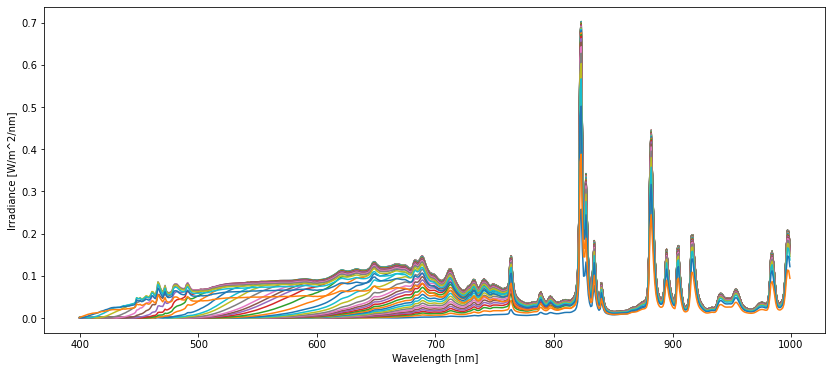

In [28]:
c_matrix, c_matrix_derivative, c_matrix_wl, c_matrix_cutwl = c_matrix_generator(full_spectra_irradiance_fit, Real_data=True, stepf_parameters=RS_stepf_parameters_short, Red_sweep=True, Derivative = True)
#Here we plot the c_matrix spectra irradiance to chech that everithing is OK.
c_matrix =abs(c_matrix)
fig, ax = plt.subplots(figsize=(14,6))
for i in range(len(c_matrix[:,0])):
    ax.plot(c_matrix_wl, c_matrix[i,:])
#plt.ylim(0,05)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Irradiance [W/m^2/nm]')

In [ ]:
#This script is to talculate a theorecial c_matrix with the same fwhm
c_matrix, c_matrix_derivative, c_matrix_wl, c_matrix_cutwl = c_matrix_generator(full_spectra_irradiance_fit, Red_sweep=True, Derivative = True)
#Here we plot the c_matrix spectra irradiance to chech that everithing is OK.
fig, ax = plt.subplots(figsize=(14,6))
for i in range(len(c_matrix[:,0])):
    ax.plot(c_matrix_wl, c_matrix[i,:])
#plt.ylim(0,05)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Irradiance [W/m^2/nm]')

Calculate Jsc

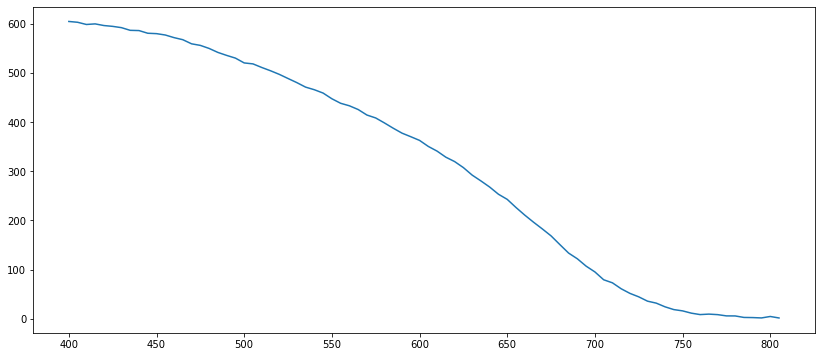

In [29]:
#Here we will calcualte the Jsc from the c_matrix and the EQE: 
calculated_Jsc_c_matrix, calculated_Jsc_c_matrix_wl, calculated_Jsc_c_matrix_cutwl = c_matrix_generator(full_spectra_irradiance_fit, Red_sweep=True, Derivative = False, c_matrix_res_wl=1)
calculated_Jsc = np.zeros(len(calculated_Jsc_c_matrix[:,0]))
for i in range(len(calculated_Jsc_c_matrix[:,0])):
    calculated_Jsc[i] = sum(calculated_Jsc_c_matrix[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
    calculated_Jsc[i] = calculated_Jsc[i]+5*np.random.random_sample()
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(calculated_Jsc_c_matrix_cutwl, calculated_Jsc)

Solve the EQE with the derivative alejando method

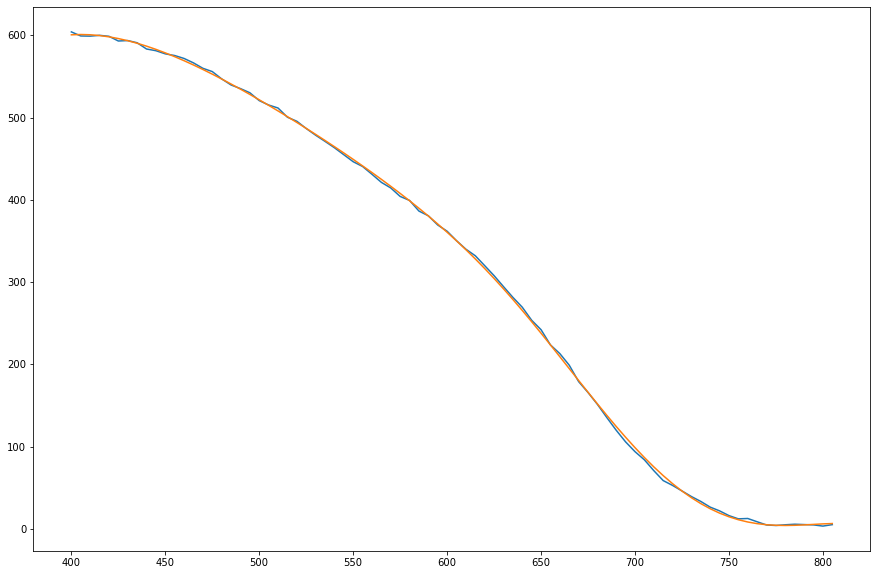

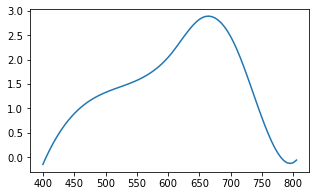

In [42]:
#First of all, for simplicity we will fit the calculated Jsc with splines

calculated_Jsc_fit = interpolate.UnivariateSpline(calculated_Jsc_c_matrix_cutwl,calculated_Jsc, s=500, k=4)
#calculated_Jsc_fit_2 = interpolate.LSQUnivariateSpline(calculated_Jsc_c_matrix_cutwl,calculated_Jsc, np.linspace(knots_min, knots_max, knots_points))

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(calculated_Jsc_c_matrix_cutwl,calculated_Jsc, label='Calcualted Jsc')
ax.plot(calculated_Jsc_c_matrix_cutwl,calculated_Jsc_fit(calculated_Jsc_c_matrix_cutwl))
#ax.plot(calculated_Jsc_c_matrix_cutwl,calculated_Jsc_fit_2(calculated_Jsc_c_matrix_cutwl))

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(calculated_Jsc_c_matrix_cutwl, -calculated_Jsc_fit.derivative(n=1)(calculated_Jsc_c_matrix_cutwl))
#ax.plot(calculated_Jsc_c_matrix_cutwl, -calculated_Jsc_fit_2.derivative(n=1)(calculated_Jsc_c_matrix_cutwl))
calculated_Jsc_derivative = -calculated_Jsc_fit.derivative(n=1)(calculated_Jsc_c_matrix_cutwl)

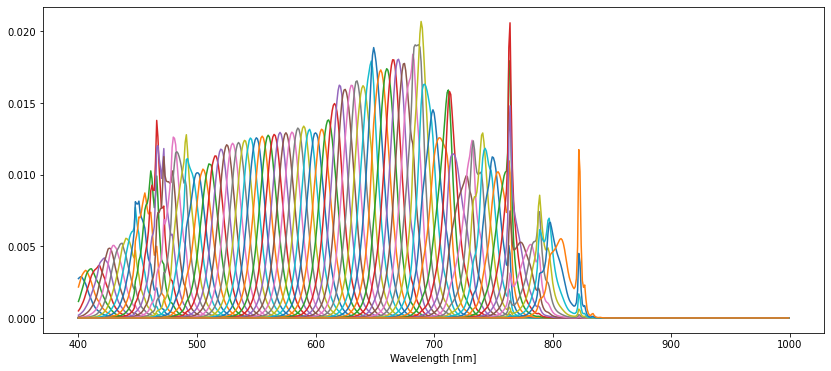

In [67]:
c_matrix_plotter(c_matrix_derivative, c_matrix_wl)


(0.0, 100.0)

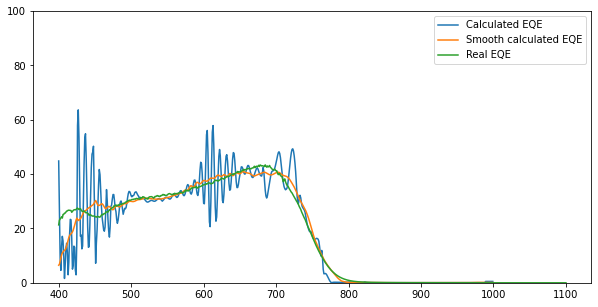

In [66]:

c_matrix_derivative_noise = c_matrix_noise_adder(c_matrix_derivative, 0)
EQE_linearsolution_all = optimize.lsq_linear(c_matrix_derivative_noise,calculated_Jsc_derivative, bounds=(0,100), lsq_solver='exact', tol=0.01, method='trf', max_iter=20000)
#print(EQE_linearsolution_all)
EQE_linearsolution = EQE_linearsolution_all.x
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(c_matrix_wl, 5*EQE_linearsolution, label='Calculated EQE')
ax.plot(c_matrix_wl, 5*smooth(EQE_linearsolution,50), label='Smooth calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
plt.legend()
plt.ylim(0,100)

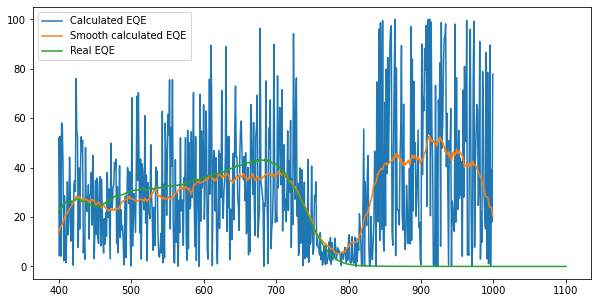

In [329]:
#EQE_linearsolution, residuals, rank, s = np.linalg.lstsq(c_matrix_derivative, calculated_Jsc_derivative, rcond=None)
c_matrix_input = c_matrix
c_matrix_noise = c_matrix_noise_adder(c_matrix_input, 20)
c_matrix_vderivative = c_matrix_vertical_derivative(c_matrix_noise, c_matrix_cutwl, s_factor = 0)
EQE_linearsolution_all = optimize.lsq_linear(c_matrix_vderivative,calculated_Jsc_derivative, bounds=(0,100), lsq_solver=None, tol=0.002, method='trf', max_iter=20000)
#print(EQE_linearsolution_all)
EQE_linearsolution = EQE_linearsolution_all.x
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(c_matrix_wl, EQE_linearsolution, label='Calculated EQE')
ax.plot(c_matrix_wl, smooth(EQE_linearsolution,50), label='Smooth calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
plt.legend()
#plt.ylim(0,100)

Red and Blue sweep for better fiting

In [166]:
c_matrix_RS, c_matrix_derivative_RS, c_matrix_wl_RS, c_matrix_cutwl_RS = c_matrix_generator(full_spectra_irradiance_fit, Red_sweep=True, Derivative = True, c_matrix_res_wl=1, c_matrix_res_cutwl=10, c_matrix_stepf_HWHM=10)
c_matrix_BS, c_matrix_derivative_BS, c_matrix_wl_BS, c_matrix_cutwl_BS = c_matrix_generator(full_spectra_irradiance_fit, Red_sweep=False, Derivative = True, c_matrix_res_wl=1, c_matrix_res_cutwl=10, c_matrix_stepf_HWHM=10)
c_matrix_RS_BS = np.vstack((c_matrix_RS, c_matrix_BS))
c_matrix_derivative_RS_BS = np.vstack((c_matrix_derivative_RS, c_matrix_derivative_BS))
calculated_Jsc_RS, calculated_Jsc_BS, calculated_Jsc_RS_cutwl, calculated_Jsc_BS_cutwl = Jsc_calculator(full_spectra_irradiance_fit, 1, real_EQE_interp, 1)
calculated_Jsc_RS_spline = interpolate.UnivariateSpline(calculated_Jsc_RS_cutwl,calculated_Jsc_RS, s=700000, k=4)
calculated_Jsc_BS_spline = interpolate.UnivariateSpline(calculated_Jsc_BS_cutwl,calculated_Jsc_BS, s=700000, k=4)
calculated_Jsc_RS_spline_derivative = calculated_Jsc_RS_spline.derivative(n=1)
calculated_Jsc_BS_spline_derivative = calculated_Jsc_BS_spline.derivative(n=1)
calculated_Jsc_derivative_RS_BS = np.hstack((-calculated_Jsc_RS_spline_derivative(c_matrix_cutwl_RS),calculated_Jsc_BS_spline_derivative(c_matrix_cutwl_BS)))

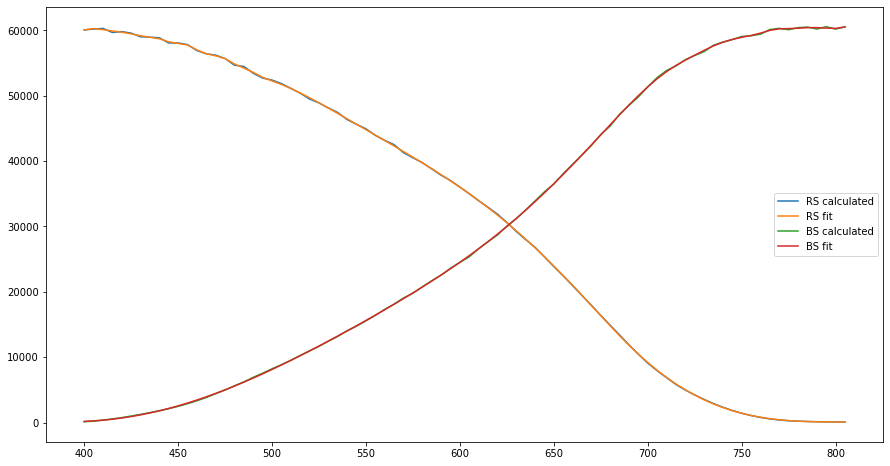

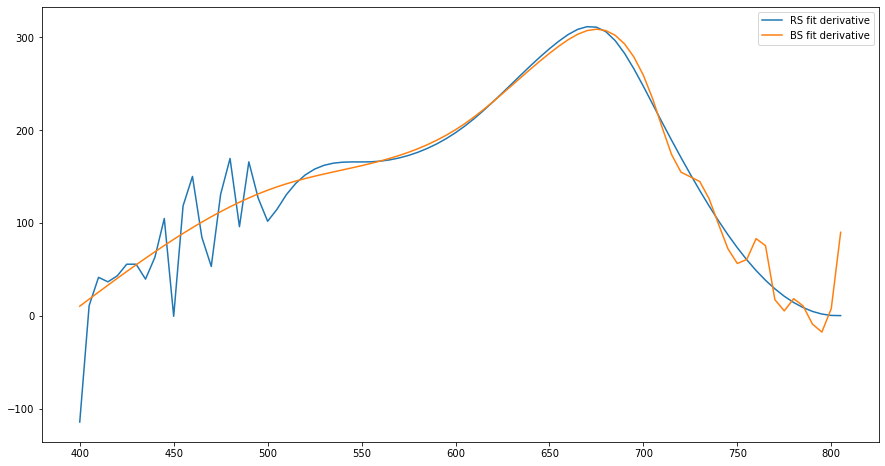

In [167]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(calculated_Jsc_RS_cutwl, calculated_Jsc_RS, label ='RS calculated')
ax.plot(calculated_Jsc_RS_cutwl, calculated_Jsc_RS_spline(calculated_Jsc_RS_cutwl), label ='RS fit')
ax.plot(calculated_Jsc_BS_cutwl, calculated_Jsc_BS, label='BS calculated')
ax.plot(calculated_Jsc_BS_cutwl, calculated_Jsc_BS_spline(calculated_Jsc_BS_cutwl), label='BS fit')
plt.legend()

fig,ax = plt.subplots(figsize=(15,8))
ax.plot(calculated_Jsc_RS_cutwl, -calculated_Jsc_RS_spline_derivative(calculated_Jsc_RS_cutwl), label = 'RS fit derivative')
ax.plot(calculated_Jsc_BS_cutwl, calculated_Jsc_BS_spline_derivative(calculated_Jsc_BS_cutwl), label = 'BS fit derivative')
plt.legend()




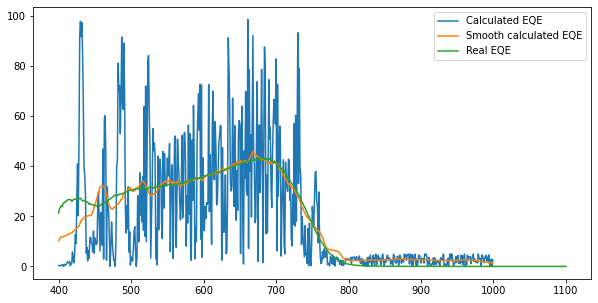

In [168]:
EQE_linearsolution_all = optimize.lsq_linear(c_matrix_derivative_RS_BS,1/10*calculated_Jsc_derivative_RS_BS, bounds=(0,100), lsq_solver='exact', tol=0.001, method='trf', max_iter=20000)
#print(EQE_linearsolution_all)
EQE_linearsolution = EQE_linearsolution_all.x
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(c_matrix_wl, EQE_linearsolution, label='Calculated EQE')
ax.plot(c_matrix_wl, smooth(EQE_linearsolution,70), label='Smooth calculated EQE')
ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
plt.legend()
#plt.ylim(0,100)